In [2]:
# Set up libraries and backend
from qiskit.tools.jupyter import * 
from qiskit import IBMQ
from qiskit import assemble
import numpy as np
import matplotlib.pyplot as plt
from qiskit import pulse
from qiskit.pulse import pulse_lib
from qiskit.pulse import Play
from qiskit.pulse.commands import SamplePulse
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import json

%config InlineBackend.figure_format = 'svg'
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support OpenPulse"

# Use for conversions later
GHz = 1.0e9
MHz = 1.0e6
kHz = 1.0e3
ms = 1.0e-3
us = 1.0e-6
ns = 1.0e-9
scale_factor = 1e-14

# Initialize qubit to |0> and retrieve backend frequencies
qubit = 0
dt = backend_config.dt
backend_defaults = backend.defaults()
qubit_props_dict = backend.properties().qubit_property(0)
rough_qubit_freq = qubit_props_dict['frequency'][0]
rough_cav_freq = backend_defaults.meas_freq_est[qubit]


# Define and configure measurement map (hardware constraint)
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in meas_map!"
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)
qubit_meas_group = backend_config.meas_map[meas_map_idx]
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=qubit_meas_group)


# Define for convenience
def get_closest_multiple_of_16(num):
    return int(num + 8) - (int(num + 8) % 16)
    
# Save and retrieve data from external text files
def save_data(dataset, file):
    filehandler = open(file, 'w')
    json.dump(dataset, filehandler)
    filehandler.close()

def load_data(file):
    filehandler = open(file)
    dataset = json.load(filehandler)
    filehandler.close()
    return dataset

# Get list of data points (complex-valued) from result of job
def get_job_data(job):
    sweep = []
    result = job.result(timeout=120)
    for i in range(len(result.results)):
        res = result.get_memory(i)*scale_factor
        sweep.append(res[qubit])
    return sweep

# Define curve fitting function
def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params, maxfev=5000)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

In [3]:
# Use values from calibration notebooks
qubit_data = loadData('QubitFrequency.txt')
mod_qubit_freq_Hz = qubit_data['wq'] # Value from experiment

# Get pi pulse parameters from calibration experiment, construct pulse

pi_data = loadData('pipulse.txt') # from calibration experiment
drive_samps_us = pi_data['drive_samps_us'] # Width of the gaussian pulse
drive_sigma_us = pi_data['drive_sigma_us'] # Truncates duration of gaussian to be finite
pi_amp = pi_data['pi_amp']

drive_samps = get_closest_multiple_of_16(drive_samps_us * us/dt) # Puts width in units of dt
drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us/dt) # Puts duration in units of dt

pi_pulse = pulse_lib.gaussian(amp=pi_amp, sigma=drive_sigma, duration=drive_samps)

In [4]:
# T1 experiment parameters
time_max_us = 450 
time_step_us = 6 
times_us = np.arange(1, time_max_us, time_step_us) # array of time delays between excitation and measurement
delay_times_dt = times_us * us / dt
t1_schedules = [] # separate schedule for each delay time
for delay in delay_times_dt:
    this_schedule = pulse.Schedule(name=f"T1 delay = {delay * dt/us} us")
    this_schedule += Play(pi_pulse, drive_chan)
    this_schedule |= measure << int(delay)
    t1_schedules.append(this_schedule)

In [19]:
# assemble schedules
num_shots = 256 # Relatively low precision, done for documentation purposes
t1_experiment = assemble(t1_schedules,
                         backend=backend, 
                         meas_level=1,
                         meas_return='avg',
                         shots=num_shots,
                         schedule_los=[{drive_chan: rough_qubit_freq}] * len(t1_schedules))

t1_job = backend.run(t1_experiment)
print(t1_job.job_id())
job_monitor(t1_job)

5f4aa98aad84b8001ad92316
Job Status: job has successfully run


In [20]:
# extract + normalize results
t1_values = get_job_data(t1_job)
mag_t1_values = [abs(value) for value in t1_values]

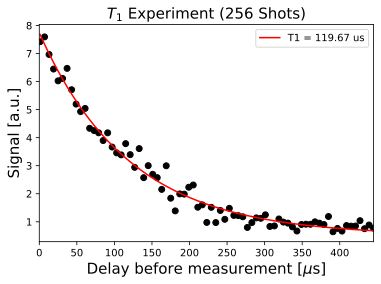

In [93]:
# Fit the data
t1_fit_params, t1_y_fit = fit_function(times_us, mag_t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [3, 3, 100]
            )

_, _, T1 = t1_fit_params

# Plot the data
plt.scatter(times_us, mag_t1_values, color='black')
plt.plot(times_us, t1_y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("$T_1$ Experiment (256 Shots)", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()
T1_s = T1 * us # puts value in seconds

In [94]:
print(f"T1 is {T1} us")

T1 is 119.67319285772773 us


In [11]:
# Run same experiment w/ more shots 
mod_shots = 1024

mod_t1_experiment = assemble(t1_schedules, backend=backend, meas_level=1, meas_return='avg', shots=mod_shots,
                            schedule_los=[{drive_chan: rough_qubit_freq}] * len(t1_schedules))

mod_t1_job = backend.run(mod_t1_experiment)
print(mod_t1_job.job_id())
job_monitor(mod_t1_job)

5f4a97e4f6e06f0019e44b40
Job Status: job has successfully run


In [12]:
mod_t1_values = get_job_data(mod_t1_job)
mag_mod_t1_values = [abs(value) for value in mod_t1_values]

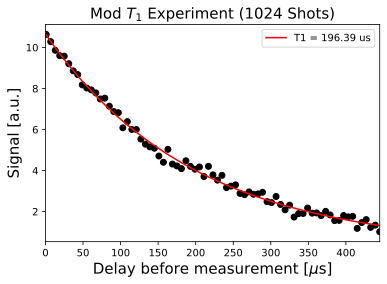

In [17]:
# Fit the data
mod_t1_fit_params, mod_t1_y_fit = fit_function(times_us, mag_mod_t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [10, 3, 100]
            )

_, _, mod_T1 = mod_t1_fit_params

# Plot the data
plt.scatter(times_us, mag_mod_t1_values, color='black')
plt.plot(times_us, mod_t1_y_fit, color='red', label=f"T1 = {mod_T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("Mod $T_1$ Experiment (1024 Shots)", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()
mod_T1_s = mod_T1 * us # puts value in seconds

In [18]:
print(f"Mod T1 is {mod_T1} us")

Mod T1 is 196.39424426911108 us


In [23]:
# Write protocol to average ~20 different sweeps on meas_return='avg'
num_trials = 20 
avg_jobIDs = []
avg_sweeps = []
# avg_mag_sweeps = []
for i in range(num_trials):
    job = backend.run(mod_t1_experiment) # swap for mod_t1_experiment if needed
    print(f"Job ID: {job.job_id()}")
    avg_jobIDs.append(job.job_id())
    job_monitor(job)
    sweep = get_job_data(job)
    
    avg_sweeps.append(sweep)
    # Use this if abs doesn't work on 2d array
    # avg_mag_sweeps.append(abs(sweep))
    
avg_mag_sweeps = [[abs(value) for value in sweep] for sweep in avg_sweeps]

Job ID: 5f4ab1e8c53d35001a7b8184
Job Status: job has successfully run
Job ID: 5f4ab8a9c53d35001a7b824d
Job Status: job has successfully run
Job ID: 5f4ac0bdbe2c6a001b649cb9
Job Status: job has successfully run
Job ID: 5f4ac858ad84b8001ad925cd
Job Status: job has successfully run
Job ID: 5f4acbf02cfd0a001a4a972f
Job Status: job has successfully run
Job ID: 5f4acc4cf6e06f0019e45073
Job Status: job has successfully run
Job ID: 5f4acca9422a86001db9f0e1
Job Status: job has successfully run
Job ID: 5f4acd1deb9d11001a5d7548
Job Status: job has successfully run
Job ID: 5f4acd78422a86001db9f0f4
Job Status: job has successfully run
Job ID: 5f4acdd3ad84b8001ad92636
Job Status: job has successfully run
Job ID: 5f4ace2e2cfd0a001a4a9755
Job Status: job has successfully run
Job ID: 5f4ace94be2c6a001b649db0
Job Status: job has successfully run
Job ID: 5f4acf1c6aac08001a7c51bb
Job Status: job has successfully run
Job ID: 5f4acf77ad84b8001ad92649
Job Status: job has successfully run
Job ID: 5f4acfd3b0c6

In [82]:
# Get statistics by considering data points at same position in each sweep 
avg_means = []
avg_stdevs = []

for i in range(len(avg_mag_sweeps[0])):
    # Build list of points at ith location in every data set
    values = []
    for j in range(len(avg_mag_sweeps)):
        values.append(avg_mag_sweeps[j][i])
    # Store mean + stdev of ith values as ith entries in the avg_means + avg_stdevs lists respectively
    avg_means.append(np.mean(values))
    avg_stdevs.append(np.std(values))


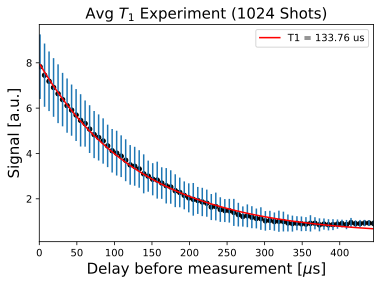

In [117]:
# Fits avg T1 decay
avg_params, avg_fit = fit_function(times_us, avg_means, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [10, 3, 100])

_, _, avg_T1 = avg_params

# Plot the data
plt.scatter(times_us, avg_means, color='black', s=20)
plt.plot(times_us, avg_fit, color='red', label=f"T1 = {avg_T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("Avg $T_1$ Experiment (1024 Shots)", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.errorbar(times_us, avg_means, avg_stdevs, fmt='none') # errorbars are 2 stdevs in length
plt.legend()
plt.show()

In [86]:
# Write protocol to average ~20 different sweeps on meas_return='single'
sing_t1_experiment = assemble(t1_schedules, backend=backend, meas_level=1, meas_return='single', shots=num_shots,
                                schedule_los=[{drive_chan: rough_qubit_freq}] * len(t1_schedules))

mod_sing_t1_experiment = assemble(t1_schedules, backend=backend, meas_level=1, meas_return='single', shots=mod_shots,
                                schedule_los=[{drive_chan: rough_qubit_freq}] * len(t1_schedules))

sing_jobIDs = []
sing_sweeps = []
for i in range(num_trials):
    job = backend.run(mod_sing_t1_experiment)
    print(f"Job ID: {job.job_id()}")
    sing_jobIDs.append(job.job_id())
    job_monitor(job)
    sweep = get_job_data(job)
    sing_sweeps.append(sweep)

Job ID: 5f4dbb3aaceafd00128ce414
Job Status: job has successfully run
Job ID: 5f4dbc5ae74b880014d14df3
Job Status: job has successfully run
Job ID: 5f4dbd8b9041660012f465b4
Job Status: job has successfully run
Job ID: 5f4dbdef3a4af800131c9635
Job Status: job has successfully run
Job ID: 5f4dbe539041660012f465bf
Job Status: job has successfully run
Job ID: 5f4dbeb8aceafd00128ce445
Job Status: job has successfully run
Job ID: 5f4dbf1b3a4af800131c9644
Job Status: job has successfully run
Job ID: 5f4dbfd6e74b880014d14e21
Job Status: job has successfully run
Job ID: 5f4dc03daceafd00128ce461
Job Status: job has successfully run
Job ID: 5f4dc0bdc95bcb0014767849
Job Status: job has successfully run
Job ID: 5f4dc127e10fb800132524c4
Job Status: job has successfully run
Job ID: 5f4dc1909041660012f465fc
Job Status: job has successfully run
Job ID: 5f4dc1f6c95bcb0014767861
Job Status: job has successfully run
Job ID: 5f4dc25e0301c600121b0208
Job Status: job has successfully run
Job ID: 5f4dc2c23a4a

In [87]:
# eliminates unnecessary array classification of individual entries in sing sweeps
sing_sweeps = [[complex(val) for val in sweep] for sweep in sing_sweeps]
sing_sweeps

[[(8.43421115744256-3.75142374965248j),
  (9.42925911425024-6.97609861726208j),
  (6.11551199363072-2.134116401152j),
  (6.46433313128448-6.55003920367616j),
  (0.2739532726272+3.48766242603008j),
  (11.43160977752064-5.65893348196352j),
  (5.86178277408768-4.66468277846016j),
  (-0.04289021083648+1.29670288769024j),
  (6.94713174720512-1.53514445635584j),
  (2.95608808112128-2.39841744781312j),
  (6.16064337575936-4.01129376579584j),
  (-1.1873105739776-0.64368519675904j),
  (-2.455500750848+2.25055598444544j),
  (9.51908567089152-5.320650784768j),
  (9.91085581041664-3.36641180827648j),
  (6.79906946056192-1.32693484371968j),
  (-1.61683691536384-0.38443384045568j),
  (14.10395990392832-2.88810814406656j),
  (-2.81296265805824+0.39979027791872j),
  (-0.49772706660352+1.48729633964032j),
  (-2.08438151872512+1.06078150852608j),
  (-2.33654743728128+2.76670770577408j),
  (-1.17624147017728-0.48688512630784j),
  (0.28536211505152+1.65008063332352j),
  (0.07284548173824-0.60726404186112j

In [88]:
# gets magnitudes of these complex values
sing_mag_sweeps = [[abs(value) for value in sweep] for sweep in sing_sweeps]

# Get statistics again
sing_means = []
sing_stdevs = []

for i in range(len(sing_mag_sweeps[0])):
    values = []
    for j in range(len(sing_mag_sweeps)):
        values.append(sing_mag_sweeps[j][i])
    sing_means.append(np.mean(values))
    sing_stdevs.append(np.std(values))

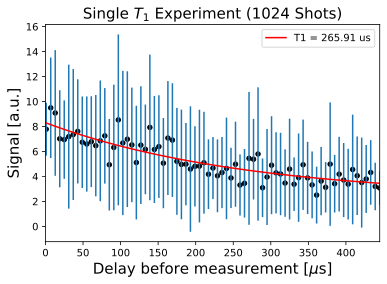

In [116]:
sing_params, sing_fit = fit_function(times_us, sing_means, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [10, 3, 100])

_, _, sing_T1 = sing_params

# Plot the data
plt.scatter(times_us, sing_means, color='black', s=20)
plt.plot(times_us, sing_fit, color='red', label=f"T1 = {sing_T1:.2f} us")
plt.xlim(0, np.max(times_us))
plt.title("Single $T_1$ Experiment (1024 Shots)", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.errorbar(times_us, sing_means, sing_stdevs, fmt='none')
plt.legend()
plt.show()

In [118]:
# Store + save relevant data

this_data = {'times_us': times_us.tolist(), 'num_shots': num_shots, 'mod_shots': mod_shots,
            'mag_t1_values': mag_t1_values, 'T1_256': T1,
            'mag_mod_t1_values': mag_mod_t1_values, 'mod_t1': mod_T1, 'num_trials': num_trials, 
             'avg_means': avg_means, 'avg_stdevs': avg_stdevs, 'avg_t1': avg_T1, 'avg_jobIDs': avg_jobIDs,
            'sing_jobIDs': sing_jobIDs, 'sing_means': sing_means, 'sing_stdevs': sing_stdevs, 'sing_t1': sing_T1
            }

save_data(this_data, 'Inversion.txt')
save_data(this_data, 'Inversion_1.txt')